In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_ring_data(
    samples: int = 500,
    radius: float = 1.0,
    noise: float = 0.1,
    normal_vector: np.ndarray = np.array([0, 0, 1]),
):
    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)

    # Generate points in the XY plane
    t = np.linspace(0, 2 * np.pi, samples)
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    z = np.zeros_like(x)
    points = np.stack([x, y, z], axis=1)

    # Find a rotation matrix to align the Z-axis with the normal vector
    z_axis = np.array([0, 0, 1])
    v = np.cross(z_axis, normal_vector)
    s = np.linalg.norm(v)
    c = np.dot(z_axis, normal_vector)

    if s != 0:  # Avoid divide by zero if the normal vector is already aligned
        vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        rotation_matrix = np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))
    else:
        rotation_matrix = np.eye(3)

    # Rotate points to align with the normal vector
    rotated_points = points @ rotation_matrix.T

    # Add Gaussian noise
    noisy_points = rotated_points + np.random.normal(
        scale=noise, size=rotated_points.shape
    )

    return noisy_points

In [3]:
def generate_spiral_data(
    samples: int = 500, radius: float = 1.0, noise: float = 0.1
) -> np.ndarray:
    t = np.linspace(0, 4 * np.pi, samples)
    x = np.cos(t) * radius
    y = np.sin(t) * radius
    z = t
    data = np.stack([x, y, z], axis=1)
    return data + noise * np.random.randn(samples, 3)  # Add noise

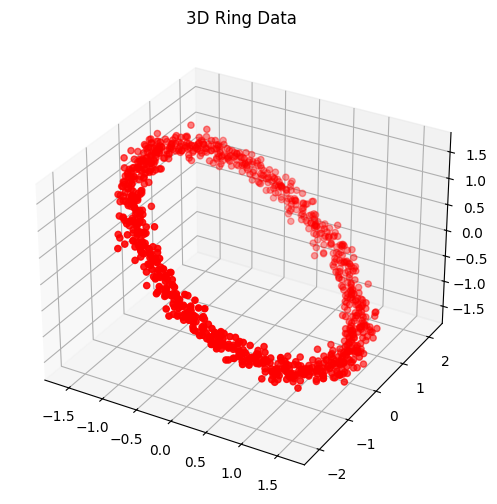

In [4]:
# Generate and plot the ring data
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

data = generate_ring_data(
    samples=1000, radius=2.0, noise=0.1, normal_vector=np.array([1, 0, 1])
)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c="r", marker="o")
ax.set_title("3D Ring Data")
fig.show()

In [5]:
import torch
from torch import nn, Tensor
from typing import Type
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange

In [6]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        input_size: int,
        intermidiate_size: int,
        hidden_size: int,
        activation: Type[nn.Module],
    ):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermidiate_size),
            activation(),
            nn.Linear(intermidiate_size, hidden_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, intermidiate_size),
            activation(),
            nn.Linear(intermidiate_size, input_size),
        )

    def encode(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def decode(self, x: Tensor) -> Tensor:
        return self.decoder(x)

    def forward(self, x: Tensor) -> Tensor:
        return self.decode(self.encode(x))

In [7]:
class Trainer(nn.Module):
    def __init__(self, model: AutoEncoder, data: np.ndarray):
        super(Trainer, self).__init__()
        self.model = model
        self.dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
        self.criterion = nn.MSELoss()

    @property
    def device(self) -> torch.device:
        return self.model.encoder[0].weight.device

    def train_loop(
        self, epochs: int, batch_size: int = 20, lr: float = 0.01, verbose: bool = True
    ):
        loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)

        self.model.train()

        for epoch in trange(epochs):
            for (data,) in loader:
                data = data.to(self.device)
                optimizer.zero_grad()
                output = self.model.forward(data)
                loss = self.criterion.forward(output, data)
                loss.backward()
                optimizer.step()
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

    def predict(self) -> tuple[np.ndarray, np.ndarray]:
        dataloader = DataLoader(self.dataset, batch_size=10)
        self.model.eval()

        hidden_reprs = []
        output_reprs = []

        with torch.no_grad():
            for (data,) in dataloader:
                data = data.to(self.device)
                hidden = self.model.encode(data)
                output = self.model.decode(hidden)
                hidden_reprs.append(hidden)
                output_reprs.append(output)

        return (
            torch.cat(hidden_reprs).cpu().numpy(),
            torch.cat(output_reprs).cpu().numpy(),
        )

In [8]:
def experiment(
    data: np.ndarray,
    hidden_dim: int,
    activation: Type[nn.Module],
    intermediate_dim: int = 128,
    seed: int = 42,
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    device = torch.device("cpu")
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        device = torch.device("cuda")

    model = AutoEncoder(data.shape[1], intermediate_dim, hidden_dim, activation)
    trainer = Trainer(model, data).to(device)
    trainer.train_loop(epochs=100, lr=0.001, verbose=False)
    return trainer.predict()

In [9]:
def visualize(
    data: np.ndarray, hidden: np.ndarray, output: np.ndarray | None = None
) -> plt.Figure:
    cmap = sns.color_palette("husl", as_cmap=True)
    colors = np.linspace(0, 1, len(data))
    fig = plt.figure(figsize=(18, 6))

    # Visualize original 3D data
    ax1 = fig.add_subplot(131, projection="3d")
    ax1.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors, marker="o", cmap=cmap)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_title("Original 3D Ring Data")

    # Visualize the hidden (latent) space representation (2D)
    ax2 = fig.add_subplot(132)
    if hidden.shape[1] > 1:
        ax2.scatter(hidden[:, 0], hidden[:, 1], c=colors, marker="o", cmap=cmap)
        ax2.set_xlabel("Hidden Dimension 1")
        ax2.set_ylabel("Hidden Dimension 2")
    else:
        ax2.scatter(hidden, hidden, c=colors, marker="o", cmap=cmap)
    ax2.set_title("Hidden Space (Latent Representation)")

    if output is None:
        fig.tight_layout()
        return fig

    # Visualize the reconstructed data
    ax3 = fig.add_subplot(133, projection="3d")
    ax3.scatter(
        output[:, 0],
        output[:, 1],
        output[:, 2],
        c=colors,
        marker="o",
        cmap=cmap,
    )
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_title("Reconstructed 3D Data")

    fig.tight_layout()
    return fig

## Non-linear dimensionality reduction

  0%|          | 0/100 [00:00<?, ?it/s]

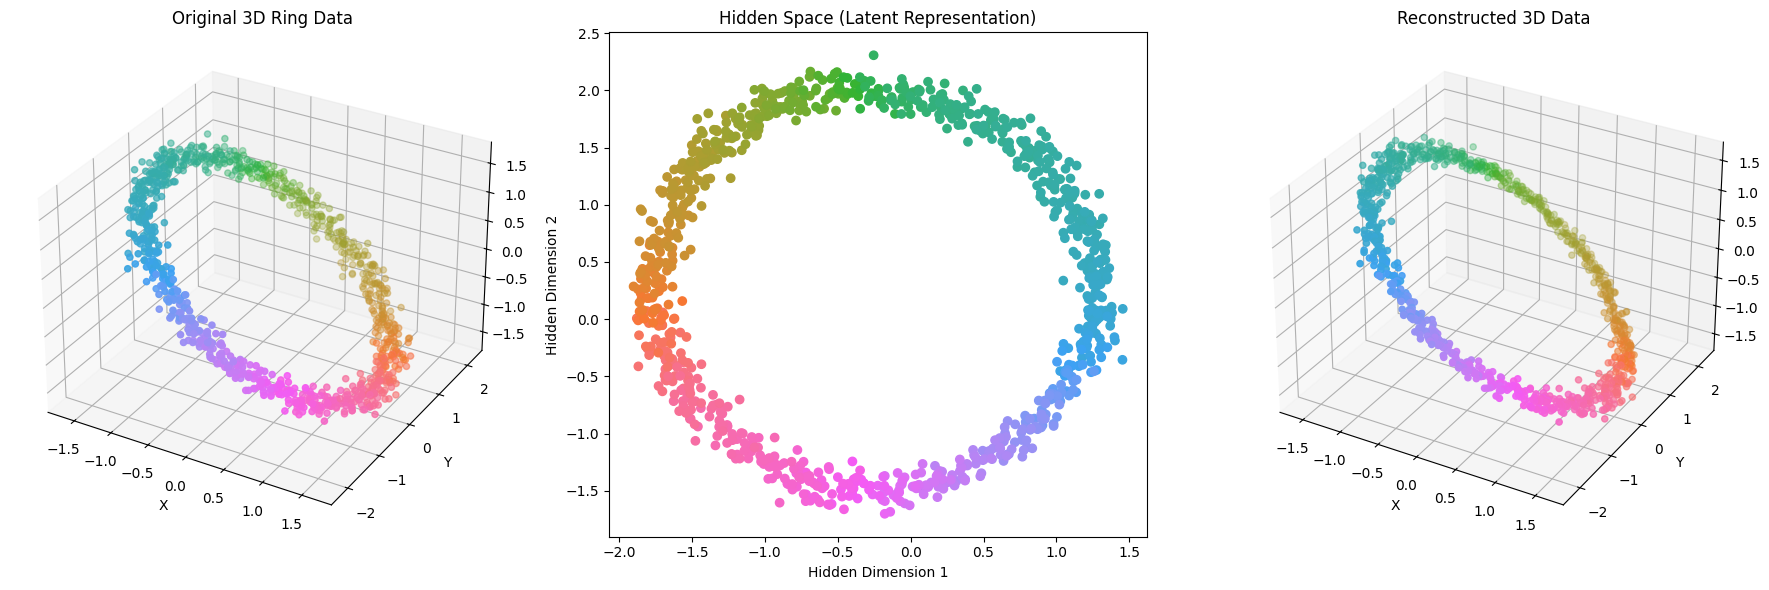

In [10]:
fig = visualize(data, *experiment(data, hidden_dim=2, activation=nn.ReLU))

  0%|          | 0/100 [00:00<?, ?it/s]

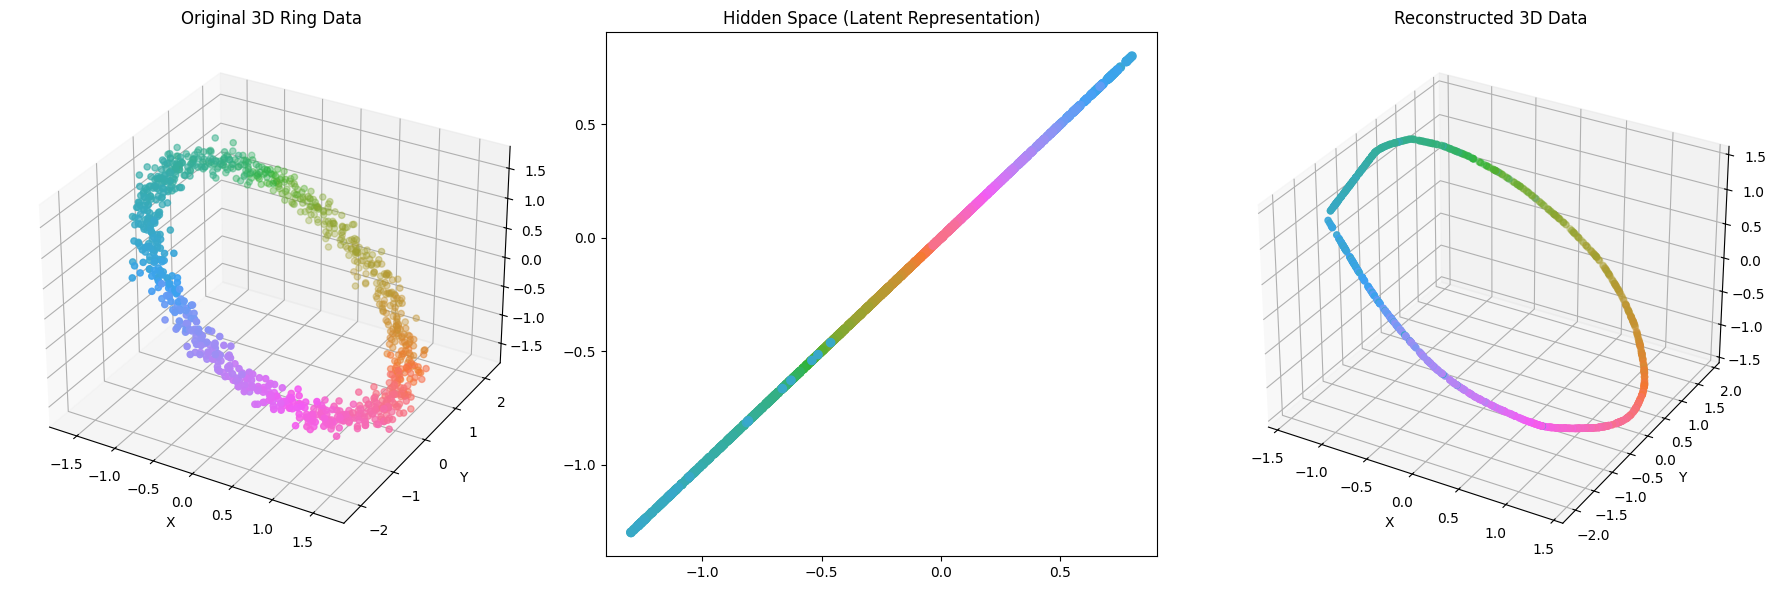

In [11]:
fig = visualize(data, *experiment(data, hidden_dim=1, activation=nn.ReLU))

  0%|          | 0/100 [00:00<?, ?it/s]

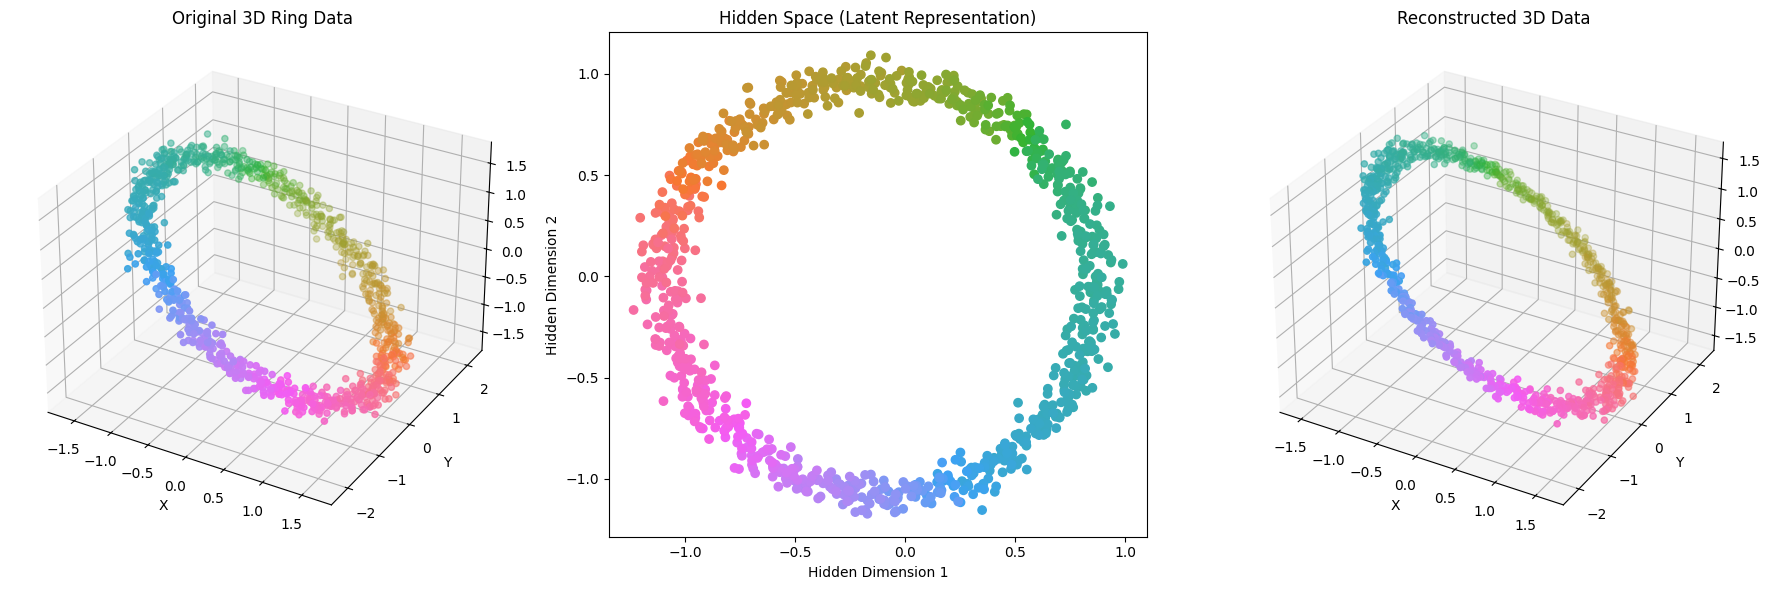

In [12]:
fig = visualize(data, *experiment(data, hidden_dim=2, activation=nn.Tanh))

  0%|          | 0/100 [00:00<?, ?it/s]

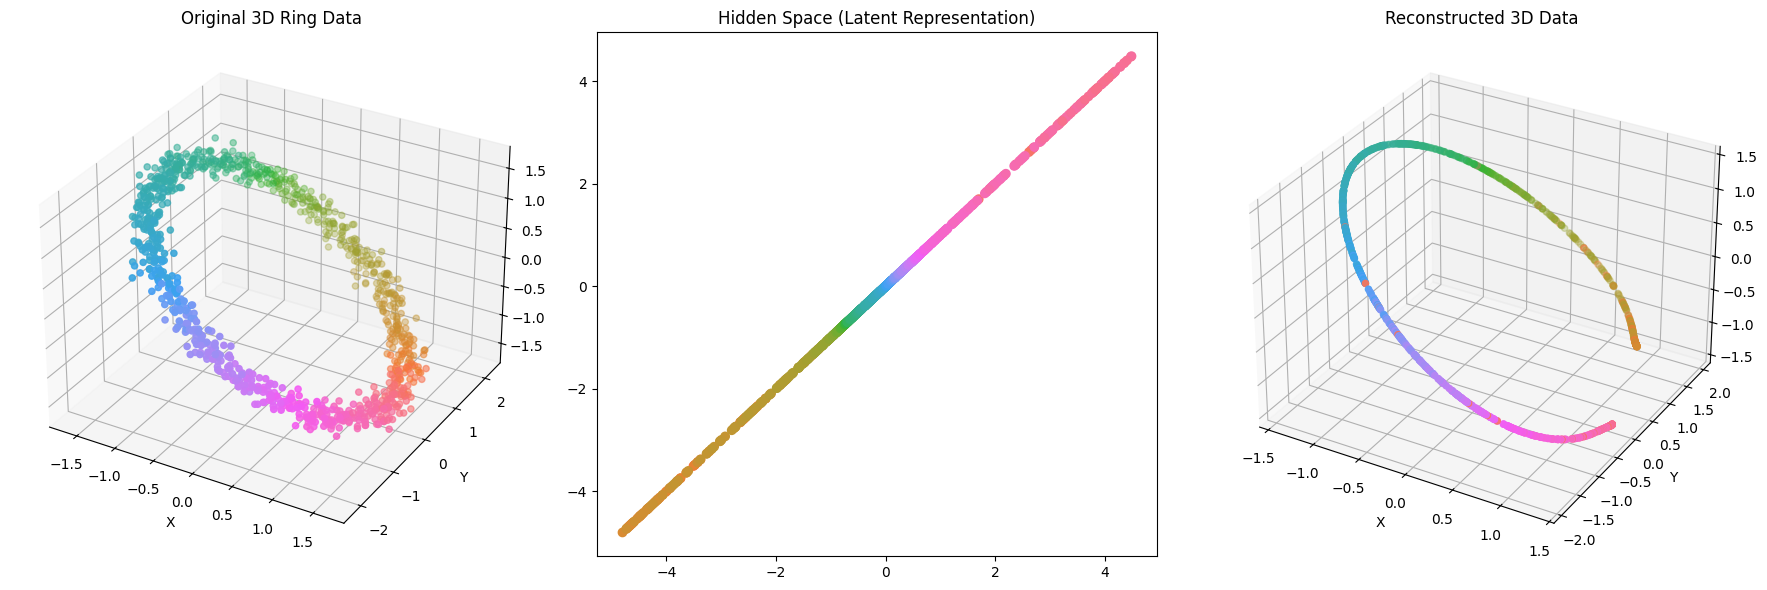

In [13]:
fig = visualize(data, *experiment(data, hidden_dim=1, activation=nn.Tanh))

## Linear dimensionality reduction

  0%|          | 0/100 [00:00<?, ?it/s]

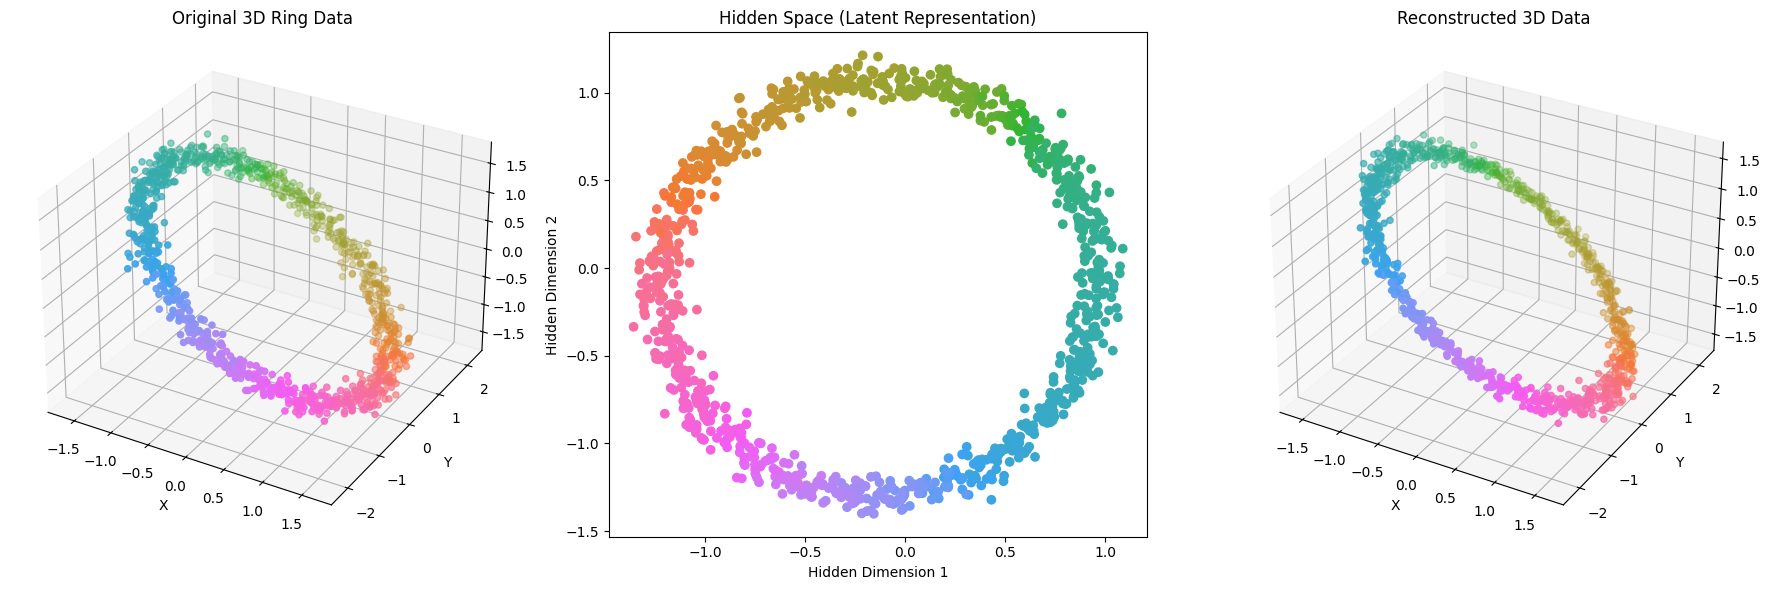

In [14]:
fig = visualize(data, *experiment(data, hidden_dim=2, activation=nn.Identity))

  0%|          | 0/100 [00:00<?, ?it/s]

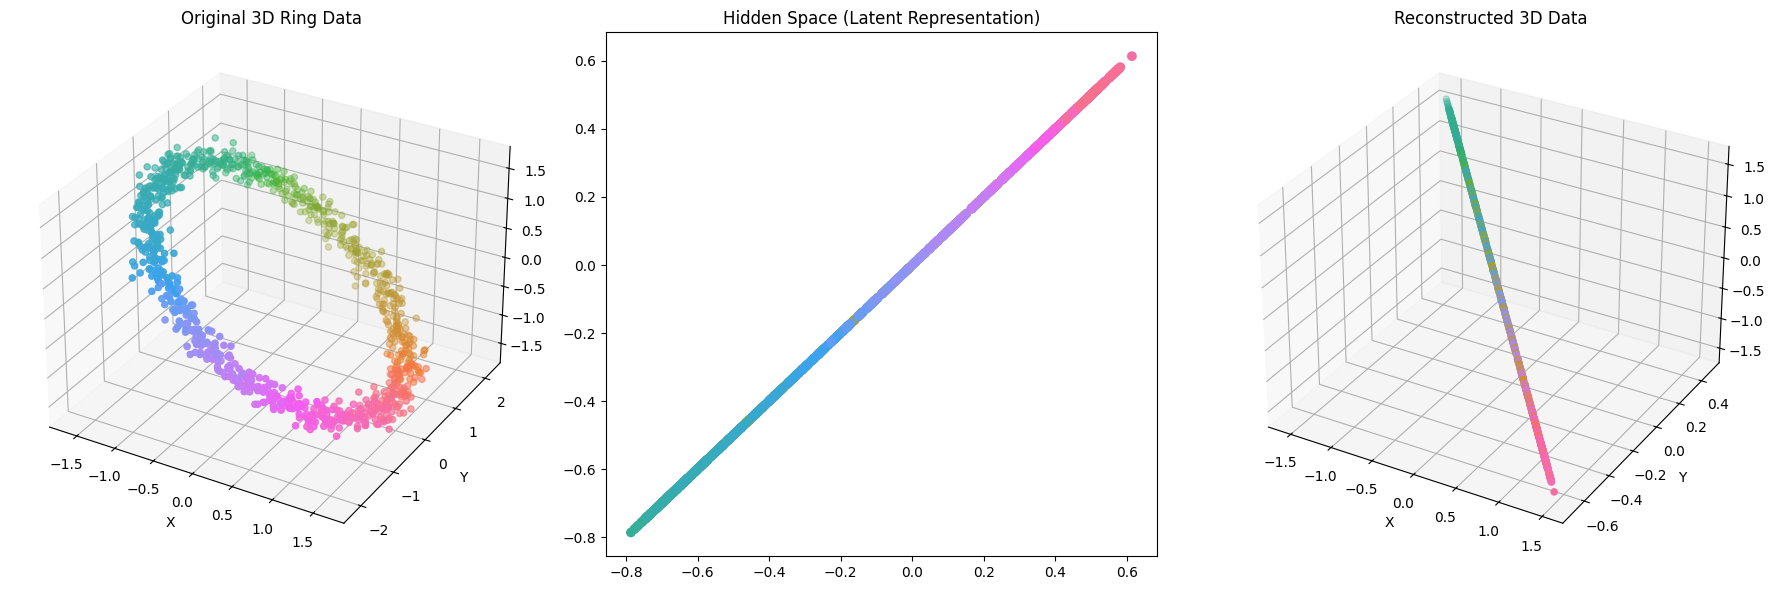

In [15]:
fig = visualize(data, *experiment(data, hidden_dim=1, activation=nn.Identity))

PC1, PC2 explains [50.11 49.62] % of total variance


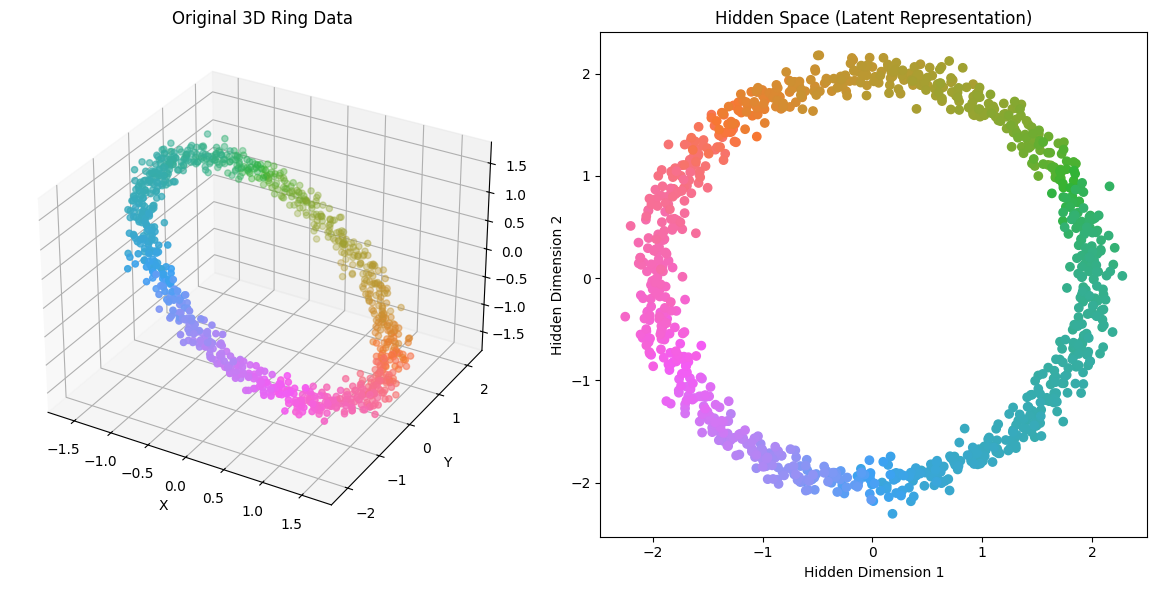

In [16]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

visualize(data, pca_data)
print(
    f"PC1, PC2 explains {pca.explained_variance_ratio_.round(4)*100} % of total variance"
)